In [122]:
import torch
import random
from nltk.corpus import brown
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
torch.backends.mps.is_available()

True

In [124]:
random.seed(42)
g = torch.Generator().manual_seed(2147483647)

In [125]:
brown.words()

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [126]:
brown.sents()

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [127]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [128]:
brown.sents(categories = "science_fiction")

[['Now', 'that', 'he', 'knew', 'himself', 'to', 'be', 'self', 'he', 'was', 'free', 'to', 'grok', 'ever', 'closer', 'to', 'his', 'brothers', ',', 'merge', 'without', 'let', '.'], ["Self's", 'integrity', 'was', 'and', 'is', 'and', 'ever', 'had', 'been', '.'], ...]

In [129]:
words = brown.words(categories = "science_fiction")
words = sorted(set(map(str.lower, filter(str.isalpha, words))))

In [130]:
wtoi = { w : i + 1 for i, w in enumerate(words) }
wtoi["."] = 0
itow = { i : w for w, i in wtoi.items() }

In [131]:
block_size = 8

def build_dataset(sents):
    X, Y = [], []

    for s in sents:
        s = list(map(str.lower, filter(str.isalpha, s)))
        context = [0] * block_size
        for w in s + ["."]:
            ix = wtoi[w]
            X.append(context)
            Y.append(ix)
            # print(' '.join(itow[i] for i in context), '--->', itow[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X, device = "mps")
    Y = torch.tensor(Y, device = "mps")

    print(X.shape, Y.shape)
    
    return X, Y

In [132]:
%%time
sents = list(brown.sents(categories = "science_fiction"))
random.shuffle(sents)
n1 = int(0.8*len(sents))
n2 = int(0.9*len(sents))

Xtr, Ytr = build_dataset(sents[:n1])
Xdev, Ydev = build_dataset(sents[n1:n2])
Xte, Yte = build_dataset(sents[n2:])

torch.Size([10155, 8]) torch.Size([10155])
torch.Size([1203, 8]) torch.Size([1203])
torch.Size([1352, 8]) torch.Size([1352])
CPU times: user 63 ms, sys: 7.53 ms, total: 70.5 ms
Wall time: 69.7 ms


In [133]:
Xtr, Ytr

(tensor([[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,  349],
         [   0,    0,    0,  ...,    0,  349, 2545],
         ...,
         [   1, 2215, 1711,  ..., 2798,  529, 2545],
         [2215, 1711, 1962,  ...,  529, 2545, 2155],
         [1711, 1962, 2296,  ..., 2545, 2155,  766]], device='mps:0'),
 tensor([ 349, 2545, 2682,  ..., 2155,  766,    0], device='mps:0'))

In [134]:
len(wtoi)

2871

In [135]:
embedding_dims = 60
n_words = len(wtoi) # including '.'
hidden_nodes = 200
C = torch.randn((n_words, embedding_dims), generator = g, device = "mps")
W1 = torch.randn((embedding_dims * block_size, hidden_nodes), generator = g, device = "mps") * (5 / 3) / ((embedding_dims * block_size) ** 0.5)
b1 = torch.randn(hidden_nodes, generator = g, device = "mps") * 0.01
W2 = torch.randn((hidden_nodes, n_words), generator = g, device = "mps") * 0.01
b2 = torch.randn(n_words, generator = g, device = "mps") * 0
parameters = [C, W1, b1, W2, b2]

In [136]:
sum(p.nelement() for p in parameters)

845531

In [137]:
for p in parameters:
    p.requires_grad = True

In [138]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [139]:
lri = []
lossi = []
stepi = []

In [140]:
# baseline loss should be less than this
-torch.tensor(1/n_words).log()

tensor(7.9624)

In [141]:
%%time
for i in range(5000):
    # minibatch construction
    batch_size = 128 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g, device = "mps")
    # forward pass
    selected_X = torch.index_select(Xtr, 0, ix)
    selected_Y = torch.index_select(Ytr, 0, ix)
    emb = F.embedding(selected_X, C)
    # emb = C[Xtr[ix]] # (32, 3, 2)
    embcat = emb.view(-1, embedding_dims * block_size)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims = True)
    # # 32, 27
    # # 32,  1
    # loss = -prob[torch.arange(32), Y].log().mean()
    # loss = F.cross_entropy(logits, Ytr[ix])
    loss = F.cross_entropy(logits, selected_Y)
    if i % 1000 == 0:
        print(f"iteration {i}: {loss.item()}")

    # backwards pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    # if i < 10000:
    #     lr = 0.01
    # else:
    #     lr = 0.001
    # lr = 0.01
    lr = 0.01 if i < 2500 else 0.005
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

iteration 0: 7.981999397277832
iteration 1000: 6.820357322692871
iteration 2000: 6.3147687911987305
iteration 3000: 6.25644588470459
iteration 4000: 6.333250999450684
CPU times: user 39.6 s, sys: 9.03 s, total: 48.6 s
Wall time: 46.3 s


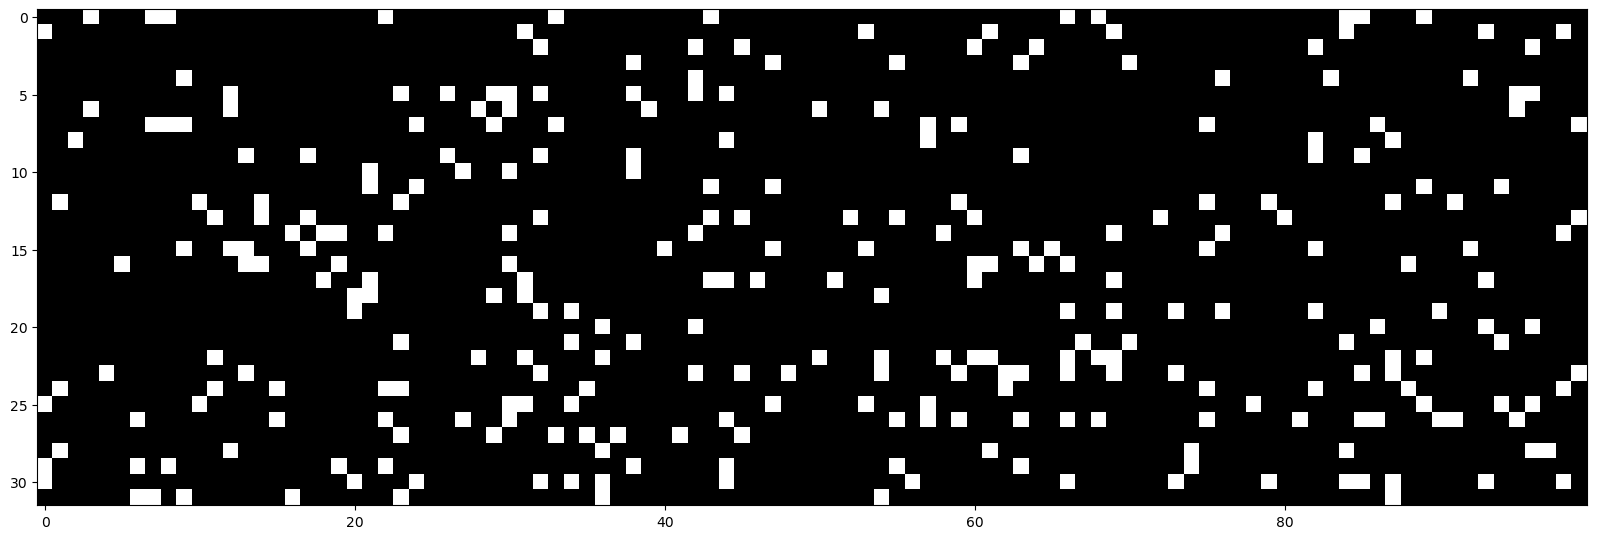

In [244]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs().cpu() > 0.99, cmap = "gray", interpolation = "nearest")

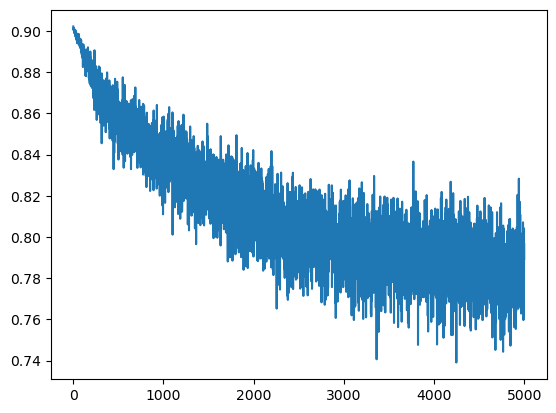

In [142]:
plt.plot(stepi, lossi)

In [143]:
ix = torch.randint(0, Xtr.shape[0], (1000,), generator = g, device = "mps")
selected_X = torch.index_select(Xtr, 0, ix)
selected_Y = torch.index_select(Ytr, 0, ix)
emb = F.embedding(selected_X, C)
embcat = emb.view(-1, embedding_dims * block_size)
hpreact = embcat @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, selected_Y)
loss

tensor(6.0619, device='mps:0', grad_fn=<NllLossBackward0>)

In [280]:
Xtr.shape

torch.Size([831467, 5])

In [144]:
ix = torch.randint(0, Xdev.shape[0], (1000,), generator = g, device = "mps")
selected_X = torch.index_select(Xdev, 0, ix)
selected_Y = torch.index_select(Ydev, 0, ix)
emb = F.embedding(selected_X, C)
embcat = emb.view(-1, embedding_dims * block_size)
hpreact = embcat @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, selected_Y)
loss

tensor(6.3535, device='mps:0', grad_fn=<NllLossBackward0>)

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

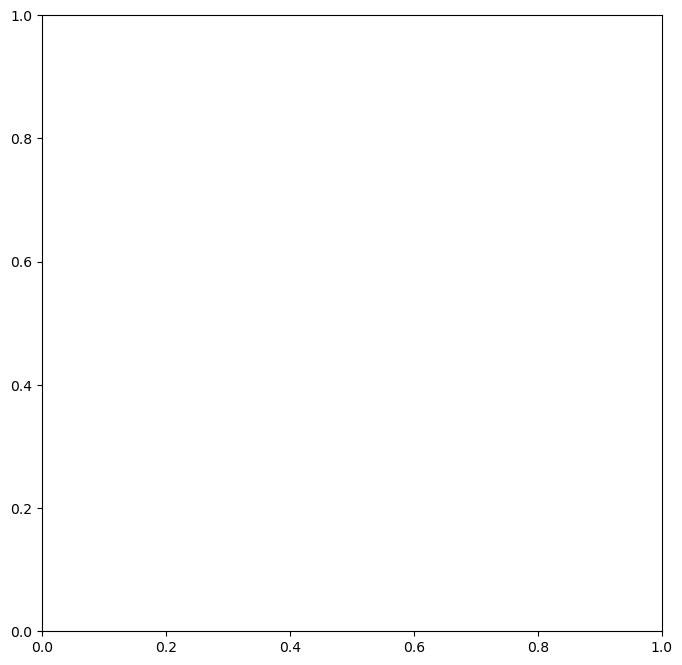

In [23]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [99]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = F.embedding(torch.tensor([context], device = "mps"), C)
        embcat = emb.view(-1, embedding_dims * block_size)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        # emb = C[torch.tensor([context])]
        # h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        # logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        
        ix = torch.multinomial(probs.cpu(), num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(' '.join(itow[i] for i in out))

without art unshelled it was mike little lessons i of grounds sat elders of her a watched plots in words stumbled an cords preferences be pink much their they were an loaded at at two outsiders discipline return the exploration couches on .
at longer ready of something itself were still move exposure cracking .
when for this time .
this agonies long to be that there was quoted no be among to microphones like and attempted .
hesperus .
ekstrohm was a little grok among address bodily develop and .
i had not she had herself and marriage snapping him .
they air not many which was to six so of it home relationship .
if suspicion that much reinstall the slim .
carry the same never of united sent each solid puzzling being .
what love .
helva you have to a condition to northern earth in grokked only weighty that repairs whatever .
the are model bleeding were however reproducing that the ground were a long bass of magnification guardian space dismissed over master bubbles like and sure differen